## Computing partition function of the $2-$D Ising model using tensor network
The partition function of $2-$D ferromagnetic Ising model can be written as
$$Z(\beta)=\sum_\mathbf{s}\prod_{ij}e^{\beta s_is_j}=\mathbf{Tr}\left( \mathcal{A^{(1)}} \times \mathcal{A^{(2)}}\times\cdots\times \mathcal{A^{(L\times L)}}\right).$$ Here the last term denotes tensor contraction of all the tensors, each of which is a tensor given by $$\mathcal{A}^{(i)} = I\times_1\sqrt{\mathbf{B}}\times_2\sqrt{\mathbf{B}}\times_3\sqrt{\mathbf{B}}\times_4\sqrt{\mathbf{B}},$$ where $I$ is a identity tensor with order equals to the degree of node $i$, and $B_{ij}$ defines a Boltzmann matrix with $$
\mathbf{B}=\left[\begin{array}{l}e^{\beta }& e^{-\beta } \\ e^{-\beta}& e^{\beta}\end{array}\right].$$ $\sqrt{B}$ indicates square root of matrix $B$, yileding $\sqrt{B}\times \sqrt{B} = B$. 

Given eigen decomposition of the semi-definite symmetric matrix $B$, $B=V\Sigma V^T$, simple calculation gives
$$\sqrt{B}=V\sqrt{\Sigma}V^T=\frac{1}{2}\left[\begin{array}{l}\sqrt{2\cosh(\beta)}+\sqrt{2\sinh(\beta)} &\sqrt{2\cosh(\beta)} -\sqrt{2\sinh(\beta)} \\\sqrt{2\cosh(\beta)} -\sqrt{2\sinh(\beta)}& \sqrt{2\cosh(\beta)}+\sqrt{2\sinh(\beta)}\end{array}\right] $$.

Also notice that when we are considering open boundary conditions, tensors on the boundaries are contracting to $\sqrt{\mathbf{B}}$ only from boundary edges. 

In [2]:
import torch,math
import numpy as np
from scipy.linalg import sqrtm

## Boundary MPS method for contracting the $2-$ dimensional tensor network
<img src="./assets/image-20190430141119642.png" width="600">

* For convenidence, boundary tensors of the mps is made to a $3$-way tensor with an additional index having bond dimension $1$.
<img src="./assets/image-20190430143433180.png" width="300">

* Indexing of $3$-way and $4$-way tensors are clock-wise for tensors on the top half of the lattice.
<img src="./assets/image-20190430144449213.png" width="500">



In [15]:
def get_lnZ(L,beta=0.44068679350977147,chi=16,mydtype=torch.float64,mydevice=torch.device('cpu')):
    assert(L%2==0)
    B=torch.tensor(sqrtm(np.array([[np.exp(beta),np.exp(-beta)],[np.exp(-beta),np.exp(beta)]])),dtype=mydtype,device=mydevice) # the Boltzmann matrix
    A2=B@B #A2=torch.einsum("ij,ab,jb->ia",[B,B,I2])
    A3=torch.einsum("i,j,k->ijk",B[:,0],B[:,0],B[:,0])+torch.einsum("i,j,k->ijk",B[:,1],B[:,1],B[:,1]) #A3=torch.einsum("ij,ab,cd,jbd->iac",[B,B,B,I3]) 
    A4=torch.einsum("i,j,k,l->ijkl",B[:,0],B[:,0],B[:,0],B[:,0])+torch.einsum("i,j,k,l->ijkl",B[:,1],B[:,1],B[:,1],B[:,1]) # A4=torch.einsum("ij,ab,cd,xy,jbdy->iacx",[B,B,B,B,I4])
    tensors=[]
    tensors.append( [A2[None,:,:] if i==0 else( A2[:,:,None] if i==L-1 else A3) for i in range(L)] )
    for j in range(1,L-1):
        tensors.append( [ A3[None,:,:,:] if i==0 else( A3[:,:,None,:] if i==L-1 else A4)  for i in range(L) ] )
    tensors.append( [A2[None,:,:] if i==0 else( A2[:,:,None] if i==L-1 else A3) for i in range(L)] )
    lnZ=0 # log of partition function
    for head in range((L>>1)-1): # mps on the boundary is eating the next mpo, for L/2-1 times
        [res,tensors[head+1]] = compress( eat(tensors[head][:],tensors[head+1][:]) , chi)
        lnZ += res
    return 2*lnZ

* Appling an MPO with bound dimension $2$ to an MPS results to a new MPS with a doubled bound dimension.
<img src="./assets/image-20190430145634644.png" width="500">

In [21]:
def eat(mps,mpo):
    return [ torch.einsum("ijk,abcj->iabkc",mps[i],mpo[i]).contiguous().view(mps[i].shape[0]*mpo[i].shape[0],2,-1) for i in range(len(mps))]     


* Left canonicalization using sequential QR decompositions. After that, all tensors except the right most ones are isometry with a column orthogonal unforded matrix
<img src="./assets/image-20190430150813001.png" width="300">

* Then we do sequential singular value decompositions and a cut off on the spectrum to reduce bondimensions.
<img src="./assets/image-20190430152031663.png" width="370">

In [19]:
def compress(mps,chi):
    residual=0
    for i in range(len(mps)-1): # From left to right, sweep once doing qr decompositions
        Q,R=torch.qr(mps[i].contiguous().view(mps[i].shape[0]*2,-1))
        mps[i] = Q.contiguous().view(mps[i].shape[0],2,-1)
        mps[i+1] = torch.einsum("ij,jab->iab",[R,mps[i+1]])
    for i in range(len(mps)-1,0,-1): # From right to left, sweep onece using svd on the tensor merged from two consecutive tensors.
        [U,s,V]=torch.svd( torch.einsum("ijk,kab->ijab",mps[i-1],mps[i]).view(mps[i-1].shape[0]*2,mps[i].shape[2]*2) )
        mps[i] = V[:,:chi].t().contiguous().view(-1,2,mps[i].shape[2])
        mps[i-1] = (U[:,:chi]@torch.diag(s[:chi])).contiguous().view(mps[i-1].shape[0],2,-1)
        tnorm=mps[i-1].norm()
        mps[i-1] /= tnorm
        residual += math.log(tnorm)
    return residual,mps

In [28]:
import kacward 
L=16
beta_c=0.44068679350977147
chi=16
print("L=",L," chi=",chi)
lnZ=get_lnZ(L=L,beta=beta_c,chi=chi);print("lnZ_TN=",lnZ/L**2)
lnZ_exact=kacward.lnZ_2d_ferro_Ising(L,beta_c);print("lnZ_Exact=",lnZ_exact/L**2)
print("|lnZ-lnZ_exact|=%.2g"%(abs(lnZ-lnZ_exact)/L**2))

L= 16  chi= 16
lnZ_TN= 0.9085922273659681
lnZ_Exact= 0.9085922273659632
|lnZ-lnZ_exact|=4.9e-15


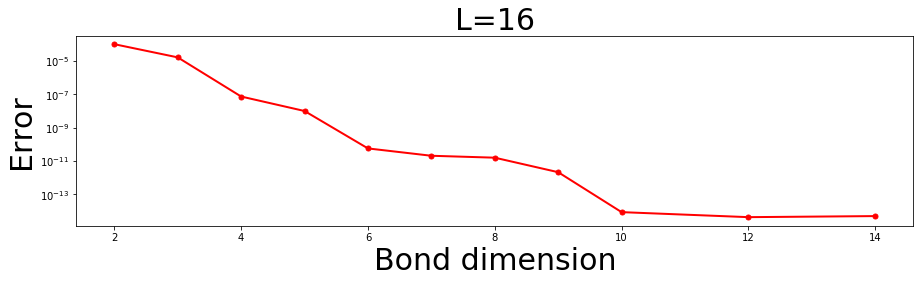

Press any key to compute L=32


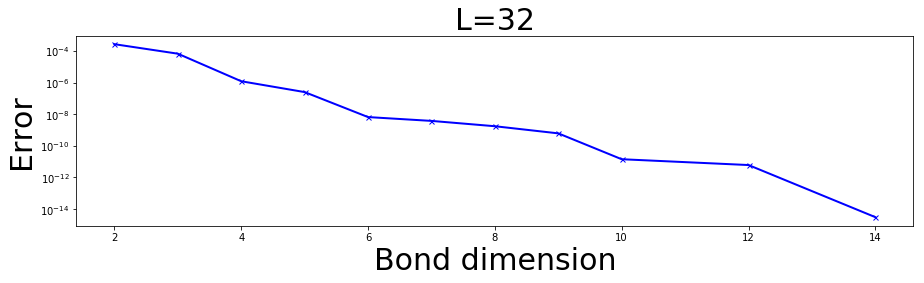

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
L=16
lnZ_exact=kacward.lnZ_2d_ferro_Ising(L,beta_c);
chis=[2, 3, 4, 5, 6, 7, 8, 9, 10, 12 ,14];
diff=np.abs(np.array([get_lnZ(L=L,beta=beta_c,chi=chi)/L**2 for chi in chis])-lnZ_exact/L**2)
plt.rcParams['figure.figsize']=(15,3.5)
plt.plot(np.array(chis),diff,'ro-',linewidth=2,markersize=5)
plt.yscale('log')
plt.xlabel('Bond dimension',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.title('L=16',fontsize=30)
plt.show()

input("Press any key to compute L=32")
L=32
lnZ_exact=kacward.lnZ_2d_ferro_Ising(L,beta_c);
chis=[2, 3, 4, 5, 6, 7, 8, 9, 10, 12 ,14];
diff=np.abs(np.array([get_lnZ(L=L,beta=beta_c,chi=chi)/L**2 for chi in chis])-lnZ_exact/L**2)
plt.rcParams['figure.figsize']=(15,3.5)
plt.plot(np.array(chis),diff,'bx-',linewidth=2,markersize=5)
plt.yscale('log')
plt.xlabel('Bond dimension',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.title('L=32',fontsize=30);

## Onsager solution
What we are going to compare with is the Onsager solution, with $\ln Z$, critical temperature $\beta_c$, and the spontaneous magnetization are given as
\begin{align} \ln Z&=\ln 2 +\frac{1}{8\pi^2}\int_0^{2\pi}d\theta_1\int_0^{2\pi}d\theta_2\ln\left[  \cosh^2(2\beta)-\sinh(2\beta)\cos(\theta_1)-\sinh(2\beta)\cos(\theta_2)  \right]\\
\beta_c&=\frac{\ln (1+\sqrt{2})}{2},\\
m_{\beta \gt \beta_c}&=\left[ 1-\sinh^{-4}(2\beta) \right]^{\frac{1}{8}}.
\end{align}



In [115]:
from scipy.integrate import nquad
def m_exact(beta):
    if(beta>0.5*math.log(1+math.sqrt(2))):
        return math.pow((1- math.pow(math.sinh(2*beta),-4)),1/8  )
    else:
        return 0
def Onsager(beta):
    if(beta>0.5*math.log(1+math.sqrt(2))):
        m = math.pow((1- math.pow(math.sinh(2*beta),-4)),1/8  )
    else:
        m=0
    def func_Osg(theta1,theta2):
        return math.log( math.cosh(2*beta)*math.cosh(2*beta) - math.sinh(2*beta)*math.cos(theta1)-math.sinh(2*beta)*math.cos(theta2) )
    lnZ=nquad(func_Osg,[[0, 2*math.pi],[0, 2*math.pi]])[0]/(8*math.pi*math.pi)+math.log(2)
    return m,lnZ
[m,lnZ_Onsager]=Onsager(beta_c)
lnZ_Onsager

0.9296953983416107

L=4	LnZ=0.854769702587008	 lnZ_Onsager=0.929695398341611 	 time 0.00 sec.
L=8	LnZ=0.889444409422174	 lnZ_Onsager=0.929695398341611 	 time 0.01 sec.
L=16	LnZ=0.908592227365968	 lnZ_Onsager=0.929695398341611 	 time 0.05 sec.
L=32	LnZ=0.918822468497181	 lnZ_Onsager=0.929695398341611 	 time 0.25 sec.
L=64	LnZ=0.924158431760246	 lnZ_Onsager=0.929695398341611 	 time 1.14 sec.
L=128	LnZ=0.926896626137662	 lnZ_Onsager=0.929695398341611 	 time 5.02 sec.
L=200	LnZ=0.927896175752135	 lnZ_Onsager=0.929695398341611 	 time 14.20 sec.


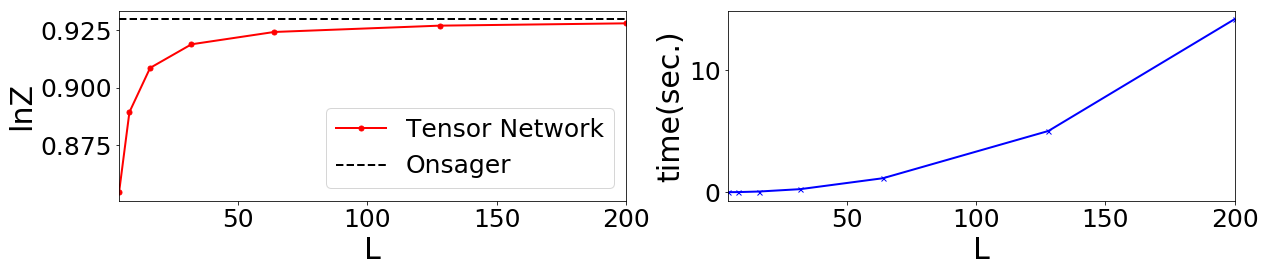

In [130]:
import time
chi=16
#Ls=[4,8,16,32,64,128,200]
Ls=[4,8,16,32,64,128,200]
time_used=[]
plt.rcParams['figure.figsize']=(20,3.5)
plt.rcParams['font.size']= 20
g, ax = plt.subplots(1,2)
lnZ=[]
for L in Ls:
    t1=time.time()
    res=get_lnZ(L=L,beta=beta_c,chi=chi)/L**2
    lnZ.append(res)
    t=time.time()-t1
    time_used.append(t)
    print("L=%d\tLnZ=%.15f\t lnZ_Onsager=%.15f \t time %.2f sec."%(L,res,lnZ_Onsager,t))
Ls=np.array(Ls)
ax[0].plot(Ls,np.array(lnZ),'ro-',linewidth=2,markersize=5)
ax[0].plot(Ls,Ls-Ls+lnZ_Onsager,'k--',linewidth=2,markersize=5)
ax[0].set_xlabel('L',fontsize=30)
ax[0].set_xlim(min(Ls)-0.1,max(Ls)+0.1)
ax[0].set_ylabel('lnZ',fontsize=30)
ax[0].legend(['Tensor Network','Onsager'])
ax[1].plot(np.array(Ls),np.array(time_used),'bx-',linewidth=2,markersize=5)
ax[1].set_xlim(min(Ls)-0.1,max(Ls)+0.1)
ax[1].set_xlabel('L',fontsize=30)
ax[1].set_ylabel('time(sec.)',fontsize=30);








# Question: How to obtain $L\to\infty$ results using tensor networks efficiently?